In [1]:
import pickle, os
import numpy as np
import pandas as pd
import petab

import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

In [2]:
datatype = "original"

# import to petab
if datatype == "original":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_original.yaml")
elif datatype == "switch":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_switch.yaml")
else:
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_loss .yaml")


# experimental data
data = np.asarray(petab_problem.measurement_df.measurement)
# time vector
tvec = np.asarray(petab_problem.measurement_df.time)

def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k1, k2, _ = x
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

In [3]:
samples_SS = np.empty([1,4])
lpost_SS = np.empty([1])
time_SS = []
ess_SS = []

foldername = './Results/Full_parameter/'
onlyfiles = [f for f in os.listdir(foldername) if os.path.isfile(os.path.join(foldername, f))]

for filename in onlyfiles:
    # standard sampling
    sample_result = pickle.load(open(foldername+filename, 'rb'))
#     sample_result.burn_in = 10000

    time_SS.append(sample_result.time)
    ess_SS.append(sample_result.effective_sample_size)

    samples_SS = np.concatenate((samples_SS,sample_result.trace_x[0, sample_result.burn_in:, :]), axis=0)
    lpost_SS = np.concatenate((lpost_SS,-sample_result.trace_neglogpost[0, sample_result.burn_in:]), axis=0)
    
time_SS = np.asarray(time_SS)
ess_SS = np.asarray(ess_SS)
samples_SS = samples_SS[1:,:]
lpost_SS = lpost_SS[1:]

In [4]:
time_HS = []
ess_HS = []
samples_HS = np.empty([1,3])
lpost_HS = np.empty([1])

foldername = './Results/Offset_marginalized/'
onlyfiles = [f for f in os.listdir(foldername) if os.path.isfile(os.path.join(foldername, f))]

for filename in onlyfiles:
    # standard sampling
    sample_result, offset_values = pickle.load(open(foldername+filename, 'rb'))
#     sample_result.burn_in = 10000
        
    time_HS.append(sample_result.time)
    ess_HS.append(sample_result.effective_sample_size)

    samples_HS = np.concatenate((samples_HS,sample_result.trace_x[0, sample_result.burn_in:, :]), axis=0)
    lpost_HS = np.concatenate((lpost_HS,-sample_result.trace_neglogpost[0, sample_result.burn_in:]), axis=0)

time_HS = np.asarray(time_HS)
ess_HS = np.asarray(ess_HS)
samples_HS = samples_HS[1:,:]
lpost_HS = lpost_HS[1:]

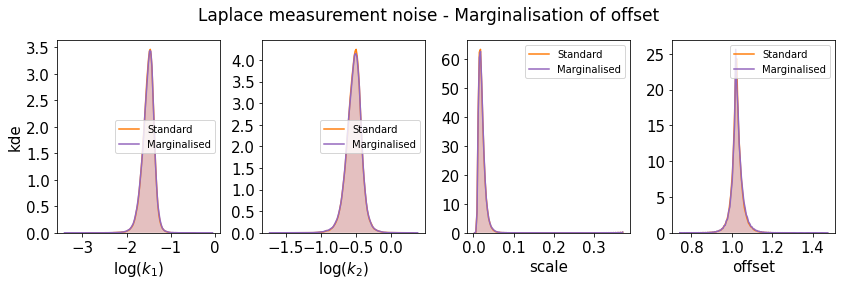

In [5]:
colors = ['tab:orange', 'tab:purple']
labels=['Standard', 'Marginal']

x_names=[r'log$(k_1)$', r'log$(k_2)$', 'scale', 'offset']

step=10

plt.figure(figsize=(12,4))
for npar in range(len(x_names)):
    
    plt.subplot(1,len(x_names),npar+1)

    sns.kdeplot(samples_SS[::step,npar], shade=True, color=colors[0], label='Standard')
    if npar < 3:
        sns.kdeplot(samples_HS[::step,npar], shade=True, color=colors[1], label='Marginalised')
    else:
        sns.kdeplot(offset_values[:,npar-3], shade=True, color=colors[1], label='Marginalised')

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    if npar == 0:
        plt.ylabel('kde',fontsize=15)
    plt.xlabel(x_names[npar],fontsize=15)
    
plt.suptitle('Laplace measurement noise - Marginalisation of offset',fontsize=17)
plt.tight_layout()

# plt.savefig('conversionReaction_Laplace_marginals.pdf', bbox_inches='tight')
plt.show()

Effective sample size
Standard: 33812.33
Marginal: 44787.7


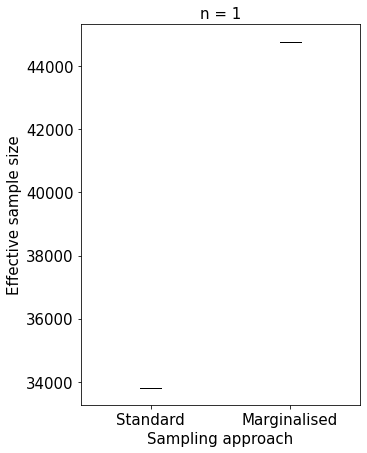

In [6]:
labels=['Standard', 'Marginalised']

print('Effective sample size')
print('Standard: '+str(round(ess_SS[0],2)))
print('Marginal: '+str(round(ess_HS[0],2)))

plt.figure(figsize=(5,7))
bplot = plt.boxplot([ess_SS, ess_HS], 
                    patch_artist=True, labels=labels,
                    medianprops=dict(color='k'))
# plt.ylim([0,0.05])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel(r'Effective sample size',fontsize=15)
plt.xlabel('Sampling approach',fontsize=15)

# fill with colors
colors = ['tab:orange', 'tab:purple']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('n = '+str(len(time_HS)),fontsize=15)

plt.show()